# Static Gesture Recognition using OpenCV and MediaPipe

This notebook demonstrates how to create a static gesture recognition system using:
- OpenCV for webcam capture and image processing
- MediaPipe for detecting body pose and hand landmarks
- Scikit-learn for training a classifier

You'll be able to collect your own training data from webcam, extract features, and train a model to recognize your gestures.

## 1. Install Required Libraries

In [1]:
!pip install opencv-python mediapipe numpy scikit-learn pandas matplotlib

## 2. Import Libraries

In [2]:
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import time
import os
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
import seaborn as sns

## 3. Initialize MediaPipe

In [3]:
# Initialize MediaPipe Pose and Hands solutions
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose
mp_hands = mp.solutions.hands

# Define drawing specs
pose_drawing_spec = mp_drawing.DrawingSpec(thickness=2, circle_radius=2, color=(0, 255, 0))
hand_drawing_spec = mp_drawing.DrawingSpec(thickness=2, circle_radius=2, color=(0, 0, 255))
connection_drawing_spec = mp_drawing.DrawingSpec(thickness=1, color=(255, 0, 0))

## 4. Create Feature Extraction Functions

In [4]:
def extract_landmarks(results):
    """Extract pose and hand landmarks from MediaPipe results"""
    features = []
    
    # Extract pose landmarks (33 landmarks × 3 coordinates = 99 features)
    if results.pose_landmarks:
        for landmark in results.pose_landmarks.landmark:
            features.extend([landmark.x, landmark.y, landmark.z])
    else:
        # If no pose detected, fill with zeros
        features.extend([0.0] * (33 * 3))
    
    # Extract left hand landmarks (21 landmarks × 3 coordinates = 63 features)
    left_hand_found = False
    if results.multi_hand_landmarks:
        for hand_idx, hand_landmarks in enumerate(results.multi_hand_landmarks):
            handedness = results.multi_handedness[hand_idx].classification[0].label
            if handedness == "Left":
                left_hand_found = True
                for landmark in hand_landmarks.landmark:
                    features.extend([landmark.x, landmark.y, landmark.z])
                break
    
    if not left_hand_found:
        # If no left hand detected, fill with zeros
        features.extend([0.0] * (21 * 3))
    
    # Extract right hand landmarks (21 landmarks × 3 coordinates = 63 features)
    right_hand_found = False
    if results.multi_hand_landmarks:
        for hand_idx, hand_landmarks in enumerate(results.multi_hand_landmarks):
            handedness = results.multi_handedness[hand_idx].classification[0].label
            if handedness == "Right":
                right_hand_found = True
                for landmark in hand_landmarks.landmark:
                    features.extend([landmark.x, landmark.y, landmark.z])
                break
    
    if not right_hand_found:
        # If no right hand detected, fill with zeros
        features.extend([0.0] * (21 * 3))
    
    return features

def normalize_landmarks(features):
    """Normalize landmarks relative to the body to make them scale and position invariant"""
    normalized_features = []
    
    # If we have valid pose data (check if not all zeros)
    if not all(f == 0 for f in features[:99]):
        # Use shoulders as reference points for normalization
        left_shoulder_x = features[33]  # left_shoulder x (11th landmark)
        left_shoulder_y = features[34]  # left_shoulder y
        right_shoulder_x = features[36]  # right_shoulder x (12th landmark)
        right_shoulder_y = features[37]  # right_shoulder y
        
        # Calculate shoulder width for scale normalization
        shoulder_width = np.sqrt((right_shoulder_x - left_shoulder_x)**2 + 
                                (right_shoulder_y - left_shoulder_y)**2)
        
        # Calculate midpoint between shoulders as reference point
        ref_x = (left_shoulder_x + right_shoulder_x) / 2
        ref_y = (left_shoulder_y + right_shoulder_y) / 2
        
        # Normalize all landmarks
        for i in range(0, len(features), 3):
            if shoulder_width > 0:
                # Normalize x and y coordinates relative to shoulder midpoint and width
                normalized_features.append((features[i] - ref_x) / shoulder_width)
                normalized_features.append((features[i+1] - ref_y) / shoulder_width)
                # Keep z values but normalize by shoulder width for scale invariance
                normalized_features.append(features[i+2] / shoulder_width)
            else:
                # If reference points are invalid, keep original values
                normalized_features.extend(features[i:i+3])
    else:
        # If no valid pose data, return original features
        normalized_features = features
        
    return normalized_features

## 5. Data Collection Function

In [6]:
def collect_training_data(gesture_name, num_samples=20, countdown=10):
    """Collect training data for a specific gesture"""
    # Create directory for saving data if it doesn't exist
    os.makedirs('gesture_data', exist_ok=True)
    
    data = []
    labels = []
    sample_count = 0
    
    # Initialize webcam
    cap = cv2.VideoCapture(0)
    
    # Countdown before starting data collection
    start_time = time.time()
    countdown_complete = False
    
    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose, \
         mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5) as hands:
        
        while cap.isOpened():
            success, image = cap.read()
            if not success:
                print("Failed to capture image from webcam.")
                break
                
            # Flip the image horizontally for a selfie-view display
            image = cv2.flip(image, 1)
            
            # Convert the BGR image to RGB
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Process the image for pose and hand detection
            pose_results = pose.process(image_rgb)
            hands_results = hands.process(image_rgb)
            
            # Copy original image for display
            display_image = image.copy()
            
            # Check countdown status
            current_time = time.time()
            elapsed_time = current_time - start_time
            
            if not countdown_complete:
                remaining = countdown - int(elapsed_time)
                if remaining > 0:
                    # Display countdown
                    cv2.putText(display_image, f"Get ready! Starting in {remaining}...", (50, 50),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                else:
                    countdown_complete = True
            
            # If countdown is complete, start collecting data
            if countdown_complete:
                # Create a combined result object to pass to the feature extraction function
                combined_results = type('CombinedResults', (), {
                    'pose_landmarks': pose_results.pose_landmarks if pose_results.pose_landmarks else None,
                    'multi_hand_landmarks': hands_results.multi_hand_landmarks if hands_results.multi_hand_landmarks else None,
                    'multi_handedness': hands_results.multi_handedness if hands_results.multi_handedness else None
                })
                
                # Extract landmarks
                features = extract_landmarks(combined_results)
                
                # Normalize landmarks
                normalized_features = normalize_landmarks(features)
                
                # Append to our dataset
                data.append(normalized_features)
                labels.append(gesture_name)
                sample_count += 1
                
                # Display progress
                cv2.putText(display_image, f"Collecting: {gesture_name} - {sample_count}/{num_samples}", (50, 50),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
            # Draw landmarks on the image
            if pose_results.pose_landmarks:
                mp_drawing.draw_landmarks(
                    display_image,
                    pose_results.pose_landmarks,
                    mp_pose.POSE_CONNECTIONS,
                    landmark_drawing_spec=pose_drawing_spec,
                    connection_drawing_spec=connection_drawing_spec)
            
            if hands_results.multi_hand_landmarks:
                for hand_landmarks in hands_results.multi_hand_landmarks:
                    mp_drawing.draw_landmarks(
                        display_image,
                        hand_landmarks,
                        mp_hands.HAND_CONNECTIONS,
                        landmark_drawing_spec=hand_drawing_spec,
                        connection_drawing_spec=connection_drawing_spec)
            
            # Show the image
            cv2.imshow('MediaPipe Pose and Hands', display_image)
            
            # Check if we've collected enough samples
            if sample_count >= num_samples:
                break
                
            # Exit if ESC key is pressed
            if cv2.waitKey(5) & 0xFF == 27:
                break
    
    # Release resources
    cap.release()
    cv2.destroyAllWindows()
    
    # Save collected data
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"gesture_data/{gesture_name}_{timestamp}.pkl"
    
    with open(filename, 'wb') as f:
        pickle.dump({'data': data, 'labels': labels}, f)
    
    print(f"Collected {sample_count} samples for gesture '{gesture_name}'")
    print(f"Data saved to {filename}")
    
    return data, labels

## 6. Collect Training Data

Run the cell below for each gesture you want to train. Change the `gesture_name` and `num_samples` parameters as needed.

In [13]:
# Example: Collect data for a "Wave" gesture
# Replace "wave" with your desired gesture name
data_wave, labels_wave = collect_training_data(gesture_name="", num_samples=100)

Collected 100 samples for gesture 'you'
Data saved to gesture_data/you_20250318_175340.pkl


## 7. Combine All Collected Data

In [14]:
def combine_gesture_data(data_dir='gesture_data'):
    """Combine all gesture data files into a single dataset"""
    all_data = []
    all_labels = []
    
    # Check if directory exists
    if not os.path.exists(data_dir):
        print(f"Error: Directory '{data_dir}' does not exist.")
        return None, None
    
    # Get all pickle files in the directory
    files = [f for f in os.listdir(data_dir) if f.endswith('.pkl')]
    
    if not files:
        print(f"No data files found in '{data_dir}'")
        return None, None
    
    # Load and combine all data
    for file in files:
        file_path = os.path.join(data_dir, file)
        try:
            with open(file_path, 'rb') as f:
                data_dict = pickle.load(f)
                all_data.extend(data_dict['data'])
                all_labels.extend(data_dict['labels'])
            print(f"Loaded {len(data_dict['labels'])} samples from {file}")
        except Exception as e:
            print(f"Error loading {file}: {e}")
    
    print(f"Combined dataset has {len(all_data)} samples across {len(set(all_labels))} gesture classes")
    
    return all_data, all_labels

# Combine all collected data
all_data, all_labels = combine_gesture_data()

Loaded 100 samples from food_20250318_175210.pkl
Loaded 100 samples from me_20250318_175321.pkl
Loaded 100 samples from stop_20250318_175137.pkl
Loaded 100 samples from sun_20250318_175233.pkl
Loaded 100 samples from water_20250318_175100.pkl
Loaded 100 samples from you_20250318_175340.pkl
Combined dataset has 600 samples across 6 gesture classes


## 8. Train the Model

Training SVM model...
Test accuracy: 100.00%

Classification Report:
              precision    recall  f1-score   support

        food       1.00      1.00      1.00        23
          me       1.00      1.00      1.00        20
        stop       1.00      1.00      1.00        19
         sun       1.00      1.00      1.00        17
       water       1.00      1.00      1.00        17
         you       1.00      1.00      1.00        24

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



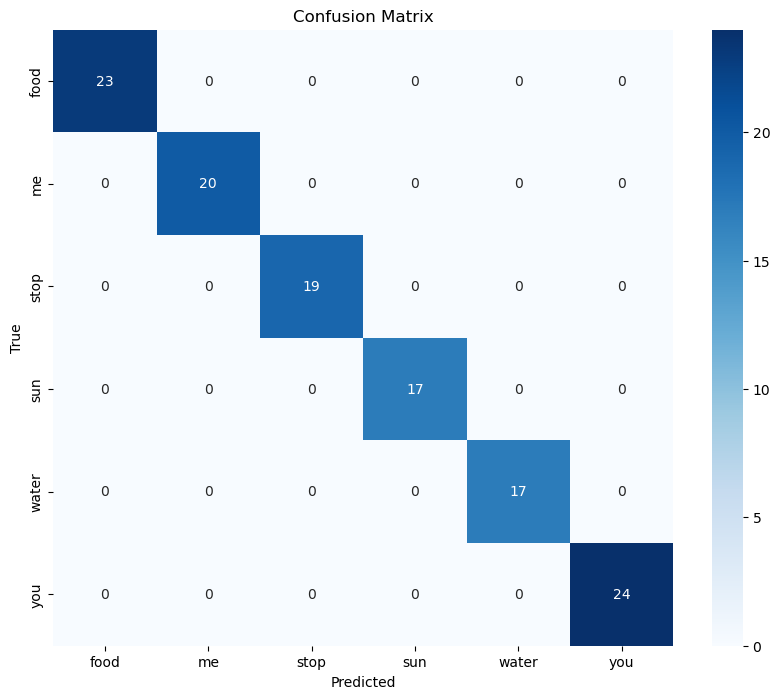

Model saved to gesture_model_svm_20250318_175357.pkl
Scaler saved to gesture_scaler_20250318_175357.pkl


In [15]:
def train_gesture_model(features, labels, model_type='svm'):
    """Train a model on the collected gesture data"""
    # Convert data to numpy arrays
    X = np.array(features)
    y = np.array(labels)
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train the model
    if model_type.lower() == 'svm':
        model = SVC(kernel='rbf', probability=True)
        print("Training SVM model...")
    else:  # Default to Random Forest
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        print("Training Random Forest model...")
    
    # Fit model
    model.fit(X_train_scaled, y_train)
    
    # Evaluate on test set
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Test accuracy: {accuracy * 100:.2f}%")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Save the model and scaler
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_filename = f"gesture_model_{model_type}_{timestamp}.pkl"
    scaler_filename = f"gesture_scaler_{timestamp}.pkl"
    
    with open(model_filename, 'wb') as f:
        pickle.dump(model, f)
    
    with open(scaler_filename, 'wb') as f:
        pickle.dump(scaler, f)
    
    print(f"Model saved to {model_filename}")
    print(f"Scaler saved to {scaler_filename}")
    
    return model, scaler

# Check if we have data to train on
if all_data and all_labels:
    # Train an SVM model
    model, scaler = train_gesture_model(all_data, all_labels, model_type='svm')
else:
    print("No training data available. Please collect data first.")

## 9. Real-time Gesture Recognition

In [22]:
def recognize_gestures(model=None, scaler=None, confidence_threshold=0.7):
    """Real-time gesture recognition using the trained model"""
    # If no model is provided, try to load the latest one
    if model is None or scaler is None:
        # Find the latest model and scaler files
        model_files = [f for f in os.listdir('.') if f.startswith('gesture_model_')]
        scaler_files = [f for f in os.listdir('.') if f.startswith('gesture_scaler_')]
        
        if not model_files or not scaler_files:
            print("No model or scaler files found. Please train a model first.")
            return
        
        latest_model = max(model_files)
        latest_scaler = max(scaler_files)
        
        try:
            with open(latest_model, 'rb') as f:
                model = pickle.load(f)
            with open(latest_scaler, 'rb') as f:
                scaler = pickle.load(f)
            print(f"Loaded model from {latest_model} and scaler from {latest_scaler}")
        except Exception as e:
            print(f"Error loading model or scaler: {e}")
            return
    
    # Initialize webcam
    cap = cv2.VideoCapture(0)
    
    # Initialize MediaPipe
    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose, \
         mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5) as hands:
        
        while cap.isOpened():
            success, image = cap.read()
            if not success:
                print("Failed to capture image from webcam.")
                break
                
            # Flip the image horizontally for a selfie-view display
            image = cv2.flip(image, 1)
            
            # Convert the BGR image to RGB
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Process the image for pose and hand detection
            pose_results = pose.process(image_rgb)
            hands_results = hands.process(image_rgb)
            
            # Copy original image for display
            display_image = image.copy()
            
            # Create a combined result object
            combined_results = type('CombinedResults', (), {
                'pose_landmarks': pose_results.pose_landmarks if pose_results.pose_landmarks else None,
                'multi_hand_landmarks': hands_results.multi_hand_landmarks if hands_results.multi_hand_landmarks else None,
                'multi_handedness': hands_results.multi_handedness if hands_results.multi_handedness else None
            })
            
            # Extract landmarks
            features = extract_landmarks(combined_results)
            
            # Normalize landmarks
            normalized_features = normalize_landmarks(features)
            
            # Make prediction if we have valid landmarks
            prediction = "No gesture detected"
            confidence = 0.0
            
            if pose_results.pose_landmarks or hands_results.multi_hand_landmarks:
                # Scale features
                scaled_features = scaler.transform([normalized_features])
                
                # Get prediction and confidence
                if hasattr(model, 'predict_proba'):
                    proba = model.predict_proba(scaled_features)[0]
                    confidence = np.max(proba)
                    if confidence >= confidence_threshold:
                        prediction = model.predict(scaled_features)[0]
                    else:
                        prediction = "Uncertain gesture"
                else:
                    prediction = model.predict(scaled_features)[0]
                    confidence = 1.0  # No confidence score available
            
            # Draw landmarks on the image
            if pose_results.pose_landmarks:
                mp_drawing.draw_landmarks(
                    display_image,
                    pose_results.pose_landmarks,
                    mp_pose.POSE_CONNECTIONS,
                    landmark_drawing_spec=pose_drawing_spec,
                    connection_drawing_spec=connection_drawing_spec)
            
            if hands_results.multi_hand_landmarks:
                for hand_landmarks in hands_results.multi_hand_landmarks:
                    mp_drawing.draw_landmarks(
                        display_image,
                        hand_landmarks,
                        mp_hands.HAND_CONNECTIONS,
                        landmark_drawing_spec=hand_drawing_spec,
                        connection_drawing_spec=connection_drawing_spec)
            
            # Display prediction
            cv2.putText(display_image, f"Gesture: {prediction}", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.putText(display_image, f"Confidence: {confidence:.2f}", (10, 70),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
            # Show the image
            cv2.imshow('Gesture Recognition', display_image)
            
            # Exit if ESC key is pressed
            if cv2.waitKey(5) & 0xFF == 27:
                break
    
    # Release resources
    cap.release()
    cv2.destroyAllWindows()

NameError: name 'cap' is not defined

In [23]:
# Run real-time gesture recognition using the trained model
# If you've just trained a model in this session, you can pass it directly
if 'model' in globals() and 'scaler' in globals():
    recognize_gestures(model=model, scaler=scaler)
else:
    # Otherwise it will try to load the latest saved model
    recognize_gestures()

C:\aiml\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
C:\aiml\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
C:\aiml\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
C:\aiml\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetProt

KeyboardInterrupt: 

In [25]:
# cap.release()
cv2.destroyAllWindows()

## 10. Model Evaluation and Visualization

In [ ]:
def evaluate_model_performance(features, labels, model_type='svm'):
    """Evaluate model performance using cross-validation"""
    from sklearn.model_selection import cross_val_score, KFold
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    
    # Convert data to numpy arrays
    X = np.array(features)
    y = np.array(labels)
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Create the model
    if model_type.lower() == 'svm':
        model = SVC(kernel='rbf', probability=True)
        print("Evaluating SVM model...")
    else:  # Default to Random Forest
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        print("Evaluating Random Forest model...")
    
    # Perform cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy')
    
    print(f"Cross-validation accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    
    # Train on full dataset for feature importance (if Random Forest)
    model.fit(X_scaled, y)
    
    # Split data for confusion matrix
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
    plt.figure(figsize=(10, 8))
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Normalized Confusion Matrix')
    plt.show()
    
    # If Random Forest, show feature importance
    if model_type.lower() == 'random_forest':
        # Get feature importance
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        # Plot feature importance
        plt.figure(figsize=(12, 6))
        plt.title('Feature Importance')
        plt.bar(range(20), importances[indices[:20]], align='center')
        plt.xticks(range(20), [f'Feature {i}' for i in indices[:20]], rotation=90)
        plt.tight_layout()
        plt.show()
        
        # Print most important features
        print("\nTop 10 most important features:")
        for i in range(10):
            print(f"Feature {indices[i]}: {importances[indices[i]]:.4f}")
    
    return model, scaler

# Check if we have data to evaluate
if 'all_data' in globals() and 'all_labels' in globals() and all_data and all_labels:
    # Example: Evaluate Random Forest model
    evaluate_model_performance(all_data, all_labels, model_type='random_forest')
else:
    print("No data available for evaluation. Please collect and combine data first.")

## 11. Visualize Collected Data

In [ ]:
def visualize_gesture_data(features, labels):
    """Visualize the collected gesture data using dimensionality reduction"""
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Convert data to numpy arrays
    X = np.array(features)
    y = np.array(labels)
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Perform PCA for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    # Plot PCA results
    plt.figure(figsize=(12, 10))
    plt.subplot(2, 1, 1)
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='viridis', s=100, alpha=0.8)
    plt.title('PCA Visualization of Gesture Data')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Perform t-SNE for better visualization
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X) // 5))
    X_tsne = tsne.fit_transform(X_scaled)
    
    # Plot t-SNE results
    plt.subplot(2, 1, 2)
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='viridis', s=100, alpha=0.8)
    plt.title('t-SNE Visualization of Gesture Data')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate explained variance for PCA
    pca = PCA().fit(X_scaled)
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance by PCA Components')
    plt.grid(True)
    plt.show()

# Check if we have data to visualize
if 'all_data' in globals() and 'all_labels' in globals() and all_data and all_labels:
    visualize_gesture_data(all_data, all_labels)
else:
    print("No data available for visualization. Please collect and combine data first.")

## 12. Save and Load Models

In [ ]:
def save_model(model, scaler, model_name='gesture_model'):
    """Save the trained model and scaler"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_filename = f"{model_name}_{timestamp}.pkl"
    scaler_filename = f"{model_name}_scaler_{timestamp}.pkl"
    
    with open(model_filename, 'wb') as f:
        pickle.dump(model, f)
    
    with open(scaler_filename, 'wb') as f:
        pickle.dump(scaler, f)
    
    print(f"Model saved to {model_filename}")
    print(f"Scaler saved to {scaler_filename}")
    
    return model_filename, scaler_filename

def load_model(model_filename, scaler_filename):
    """Load a trained model and scaler"""
    try:
        with open(model_filename, 'rb') as f:
            model = pickle.load(f)
        
        with open(scaler_filename, 'rb') as f:
            scaler = pickle.load(f)
        
        print(f"Model loaded from {model_filename}")
        print(f"Scaler loaded from {scaler_filename}")
        
        return model, scaler
    except Exception as e:
        print(f"Error loading model or scaler: {e}")
        return None, None

# Example usage:
# If you have a trained model and want to save it:
if 'model' in globals() and 'scaler' in globals():
    save_model(model, scaler, model_name='my_custom_gesture_model')

# To load a specific model:
# model, scaler = load_model('my_custom_gesture_model_20250318_123456.pkl', 'my_custom_gesture_model_scaler_20250318_123456.pkl')

## 13. Gesture Recording Utility

This utility helps you record a sequence of gestures with timestamps, which could be useful for creating gesture sequences or commands.

In [ ]:
def record_gesture_sequence(model=None, scaler=None, duration=30, confidence_threshold=0.7):
    """Record a sequence of gestures over time"""
    # If no model is provided, try to load the latest one
    if model is None or scaler is None:
        # Find the latest model and scaler files
        model_files = [f for f in os.listdir('.') if f.startswith('gesture_model_')]
        scaler_files = [f for f in os.listdir('.') if f.startswith('gesture_scaler_')]
        
        if not model_files or not scaler_files:
            print("No model or scaler files found. Please train a model first.")
            return
        
        latest_model = max(model_files)
        latest_scaler = max(scaler_files)
        
        try:
            with open(latest_model, 'rb') as f:
                model = pickle.load(f)
            with open(latest_scaler, 'rb') as f:
                scaler = pickle.load(f)
            print(f"Loaded model from {latest_model} and scaler from {latest_scaler}")
        except Exception as e:
            print(f"Error loading model or scaler: {e}")
            return
    
    # Initialize webcam
    cap = cv2.VideoCapture(0)
    
    # Initialize variables for recording
    gesture_sequence = []
    start_time = time.time()
    last_gesture = None
    last_gesture_time = start_time
    gesture_duration = 0
    
    # Initialize MediaPipe
    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose, \
         mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5) as hands:
        
        while cap.isOpened():
            success, image = cap.read()
            if not success:
                print("Failed to capture image from webcam.")
                break
                
            # Check if recording time is up
            current_time = time.time()
            elapsed_time = current_time - start_time
            if elapsed_time >= duration:
                break
            
            # Flip the image horizontally for a selfie-view display
            image = cv2.flip(image, 1)
            
            # Convert the BGR image to RGB
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Process the image for pose and hand detection
            pose_results = pose.process(image_rgb)
            hands_results = hands.process(image_rgb)
            
            # Copy original image for display
            display_image = image.copy()
            
            # Create a combined result object
            combined_results = type('CombinedResults', (), {
                'pose_landmarks': pose_results.pose_landmarks if pose_results.pose_landmarks else None,
                'multi_hand_landmarks': hands_results.multi_hand_landmarks if hands_results.multi_hand_landmarks else None,
                'multi_handedness': hands_results.multi_handedness if hands_results.multi_handedness else None
            })
            
            # Extract landmarks
            features = extract_landmarks(combined_results)
            
            # Normalize landmarks
            normalized_features = normalize_landmarks(features)
            
            # Make prediction if we have valid landmarks
            prediction = "No gesture detected"
            confidence = 0.0
            
            if pose_results.pose_landmarks or hands_results.multi_hand_landmarks:
                # Scale features
                scaled_features = scaler.transform([normalized_features])
                
                # Get prediction and confidence
                if hasattr(model, 'predict_proba'):
                    proba = model.predict_proba(scaled_features)[0]
                    confidence = np.max(proba)
                    if confidence >= confidence_threshold:
                        prediction = model.predict(scaled_features)[0]
                    else:
                        prediction = "Uncertain gesture"
                else:
                    prediction = model.predict(scaled_features)[0]
                    confidence = 1.0  # No confidence score available
            
            # Update gesture sequence
            if prediction != "No gesture detected" and prediction != "Uncertain gesture":
                if prediction != last_gesture:
                    # If we have a previous gesture, record its duration
                    if last_gesture is not None:
                        gesture_duration = current_time - last_gesture_time
                        gesture_sequence.append({
                            'gesture': last_gesture,
                            'start_time': last_gesture_time - start_time,
                            'duration': gesture_duration,
                            'confidence': confidence
                        })
                    
                    # Update to new gesture
                    last_gesture = prediction
                    last_gesture_time = current_time
            
            # Draw landmarks on the image
            if pose_results.pose_landmarks:
                mp_drawing.draw_landmarks(
                    display_image,
                    pose_results.pose_landmarks,
                    mp_pose.POSE_CONNECTIONS,
                    landmark_drawing_spec=pose_drawing_spec,
                    connection_drawing_spec=connection_drawing_spec)
            
            if hands_results.multi_hand_landmarks:
                for hand_landmarks in hands_results.multi_hand_landmarks:
                    mp_drawing.draw_landmarks(
                        display_image,
                        hand_landmarks,
                        mp_hands.HAND_CONNECTIONS,
                        landmark_drawing_spec=hand_drawing_spec,
                        connection_drawing_spec=connection_drawing_spec)
            
            # Display prediction and recording info
            cv2.putText(display_image, f"Gesture: {prediction}", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.putText(display_image, f"Confidence: {confidence:.2f}", (10, 70),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.putText(display_image, f"Recording: {elapsed_time:.1f}s / {duration}s", (10, 110),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
            
            # Show the image
            cv2.imshow('Gesture Recording', display_image)
            
            # Exit if ESC key is pressed
            if cv2.waitKey(5) & 0xFF == 27:
                break
    
    # Record the last gesture if there is one
    if last_gesture is not None:
        gesture_duration = time.time() - last_gesture_time
        gesture_sequence.append({
            'gesture': last_gesture,
            'start_time': last_gesture_time - start_time,
            'duration': gesture_duration,
            'confidence': confidence
        })
    
    # Release resources
    cap.release()
    cv2.destroyAllWindows()
    
    # Print and save the recorded sequence
    print("\nRecorded Gesture Sequence:")
    for i, entry in enumerate(gesture_sequence):
        print(f"{i+1}. {entry['gesture']} (Start: {entry['start_time']:.2f}s, Duration: {entry['duration']:.2f}s, Confidence: {entry['confidence']:.2f})")
    
    # Save sequence to file
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    sequence_filename = f"gesture_sequence_{timestamp}.pkl"
    
    with open(sequence_filename, 'wb') as f:
        pickle.dump(gesture_sequence, f)
    
    print(f"\nSequence saved to {sequence_filename}")
    
    return gesture_sequence

# Example: Record a 20-second gesture sequence
# gesture_sequence = record_gesture_sequence(duration=20)

## 14. Instructions for Use

1. **Collect Training Data**:
   - Define what gestures you want to recognize
   - For each gesture, run the `collect_training_data()` function with the gesture name and number of samples
   - Make sure to vary your position, lighting, and slight variations in the gesture for better generalization

2. **Combine and Process Data**:
   - Run `combine_gesture_data()` to merge all your collected data

3. **Train the Model**:
   - Use `train_gesture_model()` with the combined data
   - Try both SVM and Random Forest to see which performs better

4. **Test in Real-Time**:
   - Run `recognize_gestures()` to test your model with live webcam input

5. **Evaluate and Refine**:
   - Use `evaluate_model_performance()` and `visualize_gesture_data()` to understand your model's strengths and weaknesses
   - If needed, collect more data for gestures that are frequently misclassified

6. **Save and Share Your Model**:
   - Use `save_model()` to export your trained model
   - The model can be loaded later using `load_model()`

7. **Record Gesture Sequences**:
   - Once your model is working well, you can record sequences of gestures using `record_gesture_sequence()`
   - These can be used for creating gesture-based commands or interfaces

## Example Workflow

Here's a complete example workflow for creating a gesture recognition system that can detect three gestures: "wave", "thumbs_up", and "peace".

In [ ]:
# 1. Collect data for three different gestures
data_wave, labels_wave = collect_training_data(gesture_name="wave", num_samples=50)
data_thumbs_up, labels_thumbs_up = collect_training_data(gesture_name="thumbs_up", num_samples=50)
data_peace, labels_peace = collect_training_data(gesture_name="peace", num_samples=50)

# 2. Combine all collected data
all_data, all_labels = combine_gesture_data()

# 3. Visualize the data
visualize_gesture_data(all_data, all_labels)

# 4. Train and evaluate an SVM model
model_svm, scaler_svm = train_gesture_model(all_data, all_labels, model_type='svm')

# 5. Train and evaluate a Random Forest model
model_rf, scaler_rf = train_gesture_model(all_data, all_labels, model_type='random_forest')

# 6. Save the best performing model
# Assume the SVM model performed better
model_file, scaler_file = save_model(model_svm, scaler_svm, model_name='gesture_recognition_v1')

# 7. Test the model in real-time
recognize_gestures(model=model_svm, scaler=scaler_svm)

# 8. Record a sequence of gestures (optional)
gesture_sequence = record_gesture_sequence(model=model_svm, scaler=scaler_svm, duration=30)